In [5]:
from datasets import load_dataset
dataset = load_dataset("amazon_polarity")  
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})


In [6]:
dataset = dataset.shuffle(seed=10)
train = dataset["train"].select(range(50000)) # 50,000 rows for training
test  = dataset["test"].select(range(10000)) # 10,000 rows for validation

Index(['label', 'title', 'content'], dtype='object')


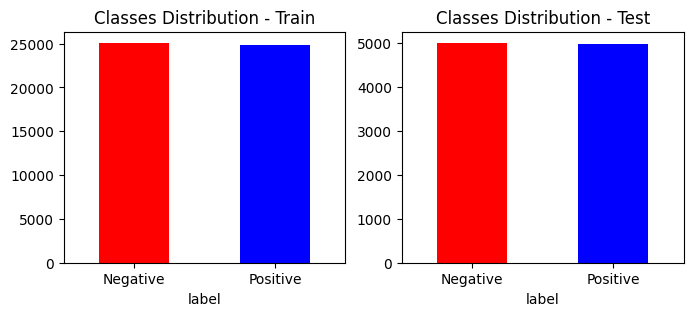

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Classes distribution for train and test datasets

train_df = pd.DataFrame(train)
test_df  = pd.DataFrame(test)

print(train_df.columns)

fig, axes = plt.subplots(1, 2, figsize=(8,3))

train_df["label"].value_counts().sort_index().plot(kind="bar", ax=axes[0], color=["red","blue"])
axes[0].set_title("Classes Distribution - Train")
axes[0].set_xticklabels(["Negative","Positive"], rotation=0)

test_df["label"].value_counts().sort_index().plot(kind="bar", ax=axes[1], color=["red","blue"])
axes[1].set_title("Classes Distribution - Test")
axes[1].set_xticklabels(["Negative","Positive"], rotation=0)

plt.show()

label
0    25104
1    24896
Name: count, dtype: int64


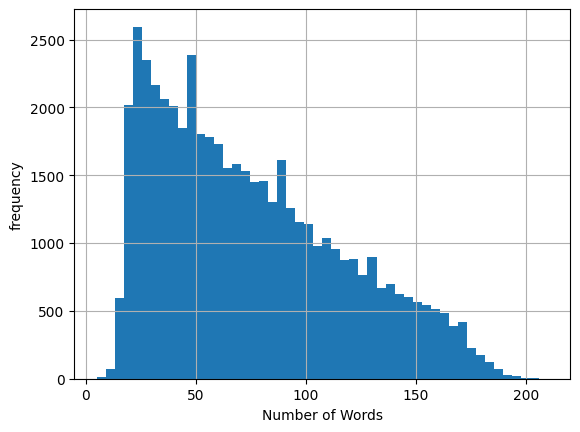

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Number of words in train reviews. In this plot we consider both positive and negative reviews.

df_train = pd.DataFrame(train)
print(df_train['label'].value_counts())

df_train['length'] = df_train['content'].str.split().str.len()
df_train['length'].hist(bins=50)
plt.xlabel("Number of Words")
plt.ylabel("frequency")
plt.show()


In [10]:
# Example of a good and a bad review from the training dataset

print("Example of a NEGATIVE review:\n")
print(train_df[train_df["label"]==0]["content"].iloc[0])

print("\n" + "="*80 + "\n")

print("Example of a POSITIVE review:\n")
print(train_df[train_df["label"]==1]["content"].iloc[0])

Example of a NEGATIVE review:

I was expecting far more from this book than I actually found in it. As another reviewer stated, it read more like a magazine article than an actual book. Writing styles aside, however, several important statements of fact as put forth by the authors were just plain wrong with some of these facts actually being contradicted by photos included within the book itself.Very disappointing. It read more like an ego-boost to the authors than a recitation of the ship & the men & the events leading up to (and following) that horrible Sunday morning in December of 1941........


Example of a POSITIVE review:

The book offered a very good review of skills needed to complete the FireFighters Civil Service exam with few errors in the answer sheets; which seem to plague other review books. Some of the material was fairly easy and I would therefore recommend using this book in conjunction with another, namely: Barron's Firefighter Exams 4th edition.I will check back in 

In [11]:
# We analize the most common single and token pairs.

from sklearn.feature_extraction.text import CountVectorizer


vectorizer_uni = CountVectorizer(stop_words="english", max_features=20)
X_uni = vectorizer_uni.fit_transform(train_df["content"]) 
uni_freq = dict(zip(vectorizer_uni.get_feature_names_out(), X_uni.sum(axis=0).A1.astype(int)))

print("Top Single Tokens:")
for word, freq in sorted(uni_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"{word}: {freq}")



# Top pairs of subsequent Tokens
vectorizer_bi = CountVectorizer(ngram_range=(2,2), stop_words="english", max_features=20)
X_bi = vectorizer_bi.fit_transform(train_df["content"])
bi_freq = dict(zip(vectorizer_bi.get_feature_names_out(), X_bi.sum(axis=0).A1.astype(int)))

print("\nTop Pairs of Subsequent Tokens:")
for word, freq in sorted(bi_freq.items(), key=lambda x: x[1], reverse=True):
    print(f"{word}: {freq}")

Top Single Tokens:
book: 25533
like: 13895
just: 12808
good: 11780
great: 11078
read: 9127
time: 8923
really: 7810
movie: 7607
don: 7287
love: 5760
buy: 5515
use: 5388
product: 5359
better: 5249
cd: 5216
bought: 5104
did: 4979
work: 4979
story: 4770

Top Pairs of Subsequent Tokens:
read book: 1251
year old: 957
waste money: 934
highly recommend: 776
don know: 770
years ago: 623
waste time: 578
reading book: 559
book read: 520
don waste: 510
ve read: 507
long time: 495
recommend book: 491
save money: 479
don buy: 463
great book: 442
don think: 419
ve seen: 402
looks like: 400
good book: 399


In [12]:
import re, unicodedata

def clean_text(s): # This function is a cleaning pipeline
    if not isinstance(s, str): return ""
    s = s.lower()                          # Convert all letters to lowercase
    s = re.sub(r'<.*?>', ' ', s)           # remove HTML labels
    s = re.sub(r'http\S+', ' ', s)         # Delete URLS
    s = unicodedata.normalize('NFKD', s)   # Convert complex unicode symbols to its base form
    s = re.sub(r'[^a-z0-9\s\.\,\!\?]', ' ', s)  # Substitute by a space any character that it is not a lowercase letter, number or common symbols
    s = re.sub(r'\s+', ' ', s).strip()      # Substitute sequences of more than one empty space for a single one
    return s

In [13]:
import torch
print(torch.cuda.is_available())  # True if a GPU is available
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060


In [14]:
import transformers
print(transformers.__version__)

4.56.1


In [12]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# This is a small version of BERT, and we use its tokenizer. num_labels=2 since we are working with binary classification
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


#This block of code is a pre processing step. It tokenizes the texts.
# truncation=True, truncates long texts
# padding='max_length', it fills short texts
# max_length defines the maximum lenght of the sequence

def tokenize(batch):
    return tokenizer(batch['content'], truncation=True, padding='max_length', max_length=256)

train_enc = train.map(tokenize, batched=True)
test_enc  = test.map(tokenize, batched=True)

train_enc.set_format('torch', columns=['input_ids','attention_mask','label'])
test_enc.set_format('torch', columns=['input_ids','attention_mask','label'])


# We define here the evaluation metrics for binary classification. Accuracy, Precession, Recall and F1
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",     # Evaluation after each epoch
    save_strategy="epoch",           # Save checkpoint at the end of each epoch
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=3,               # 3 epochs
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=True,                       
    gradient_accumulation_steps=2,   
    report_to="none"      
)

trainer = Trainer(model=model, args=args, train_dataset=train_enc, eval_dataset=test_enc, tokenizer=tokenizer, compute_metrics=compute_metrics)
trainer.train()
trainer.save_model("models/distilbert-amazon-sentiment")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Gerardo\AppData\Local\Temp\ipykernel_13736\989564370.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, train_dataset=train_enc, eval_dataset=test_enc, tokenizer=tokenizer, compute_metrics=compute_metrics)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.193400,0.203173,0.929000,0.908679,0.955177,0.931348
2,0.144000,0.235515,0.931800,0.932025,0.932765,0.932395
3,0.047300,0.277686,0.936200,0.937947,0.935343,0.936643
